<a href="https://colab.research.google.com/github/samueleborgognoni/kmeans_nn_ILF_london_smart_meters/blob/main/4_Load_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAOD FORECASTING with KMEANS-NN methodology

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

In [2]:
from google.colab import drive
drive.mount('/content/drive') # <- activate to use Google Colab

drive_folder_path = '/content/drive/MyDrive/-Career📚/_UNIVERSITY/__Macchine_ed_azionamenti_elettrici/_Progetto_MAE/mae_proj/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Import normalized dataset with extracted features for each household + cluster_id
# 750 households | 21features

df_ID = pd.read_csv(drive_folder_path + 'data/df_extracted_norm_clusters.csv')
print(df_ID.shape)

# Display the header of df
df_ID.head(5)


(750, 21)


,LCLid,TKWh,Avg_hourly,Avg_daily,Avg_weekly,Avg_monthly,Avg_Mon,Avg_Tue,Avg_Wed,Avg_Thu,...,Avg_Sat,Avg_Sun,Avg_weekend,Avg_workday,Avg_EAN,Avg_EM,Avg_LAN,Avg_M,Avg_N,cluster
0,MAC000002,0.092808,0.119064,0.119091,0.092730,0.092748,0.106704,0.115783,0.116458,0.110815,...,0.129685,0.136349,0.133041,0.113841,0.101038,0.058083,0.139120,0.134053,0.108316,0
1,MAC000005,0.044275,0.044815,0.044814,0.044193,0.044212,0.047150,0.043271,0.043760,0.040864,...,0.046777,0.048089,0.047438,0.043839,0.056807,0.033419,0.053597,0.043171,0.027675,12
2,MAC000017,0.079150,0.062699,0.062711,0.079071,0.079089,0.058711,0.054760,0.066287,0.060508,...,0.065469,0.070808,0.068158,0.060662,0.069390,0.041732,0.067978,0.070293,0.046751,4
3,MAC000026,0.154388,0.122669,0.122716,0.154316,0.154332,0.145715,0.139435,0.146693,0.133019,...,0.084117,0.096136,0.090169,0.134817,0.101975,0.118212,0.098477,0.165218,0.100686,2
4,MAC000030,0.141243,0.112202,0.112246,0.141169,0.141186,0.110712,0.084389,0.094108,0.096926,...,0.135740,0.176306,0.156168,0.095785,0.144518,0.077225,0.124258,0.126159,0.069790,5


In [4]:
def get_df_hourly(df:pd.DataFrame):
  '''Create a new pd.DataFrame with the energy measurementents
  resampled every hour'''
  # Convert timestamps from str to datetime
  df['tstp'] = pd.to_datetime(df['tstp'])
  # Resample the df
  df_hourly = (
      df
      .set_index('tstp')
      .groupby('LCLid')
      .resample('1h')['energy(kWh/hh)']
      .sum()
      .reset_index()
  )
  return df_hourly.rename(columns={'energy(kWh/hh)': 'energy(kWh)'})

# Import the time series dataset and resample it into hourly
df_time = get_df_hourly(pd.read_csv(drive_folder_path + 'data/df_cleaned.csv'))

df_time

,LCLid,tstp,energy(kWh)
0,MAC000002,2012-10-12 00:00:00,0.0
1,MAC000002,2012-10-12 01:00:00,0.0
2,MAC000002,2012-10-12 02:00:00,0.0
3,MAC000002,2012-10-12 03:00:00,0.0
4,MAC000002,2012-10-12 04:00:00,0.0
...,...,...,...
11224948,MAC005565,2012-12-19 08:00:00,0.0
11224949,MAC005565,2012-12-19 09:00:00,0.0
11224950,MAC005565,2012-12-19 10:00:00,0.0
11224951,MAC005565,2012-12-19 11:00:00,0.0


### Prepare the time dataframe for the cluster load forecasting

In [5]:
# Create a list with 10 random int
df_time_clusterID = df_time.merge(df_ID[['LCLid', 'cluster']], on='LCLid', how='left')

# Display 10 rand samples to check the cluster ID
l = np.random.randint(0, len(df_time_clusterID), 10).tolist()
df_time_clusterID.iloc[l]


,LCLid,tstp,energy(kWh),cluster
5884617,MAC003196,2013-06-02 15:00:00,0.166,12
5634246,MAC003013,2013-08-23 17:00:00,0.231,4
10521467,MAC005353,2013-06-06 05:00:00,0.280,8
5121468,MAC002741,2013-05-28 22:00:00,0.848,11
3200916,MAC001980,2013-08-17 09:00:00,0.134,12
8565960,MAC004637,2012-12-20 05:00:00,0.378,6
6414613,MAC003400,2013-11-13 16:00:00,0.199,0
8440145,MAC004543,2013-06-06 12:00:00,0.388,11
3010351,MAC001836,2012-07-12 13:00:00,1.238,1
7953806,MAC004360,2013-03-09 09:00:00,0.129,4


In [6]:
# Group hourly samples based on the cluster ID + calc the mean
df_time_mean_cluster = (
    df_time_clusterID
    .groupby(['cluster', 'tstp'])['energy(kWh)']
    .mean()
    .reset_index()
)
# df_time_mean_cluster.to_csv(drive_folder_path + 'data/df_time_mean_cluster.csv') <-- uncomment to save .csv
df_time_mean_cluster

,cluster,tstp,energy(kWh)
0,0,2011-11-28 12:00:00,0.214000
1,0,2011-11-28 13:00:00,0.183000
2,0,2011-11-28 14:00:00,0.295000
3,0,2011-11-28 15:00:00,0.194000
4,0,2011-11-28 16:00:00,0.326000
...,...,...,...
245643,12,2014-02-27 20:00:00,0.425733
245644,12,2014-02-27 21:00:00,0.412010
245645,12,2014-02-27 22:00:00,0.365426
245646,12,2014-02-27 23:00:00,0.269376


### Analyse autocorrelation

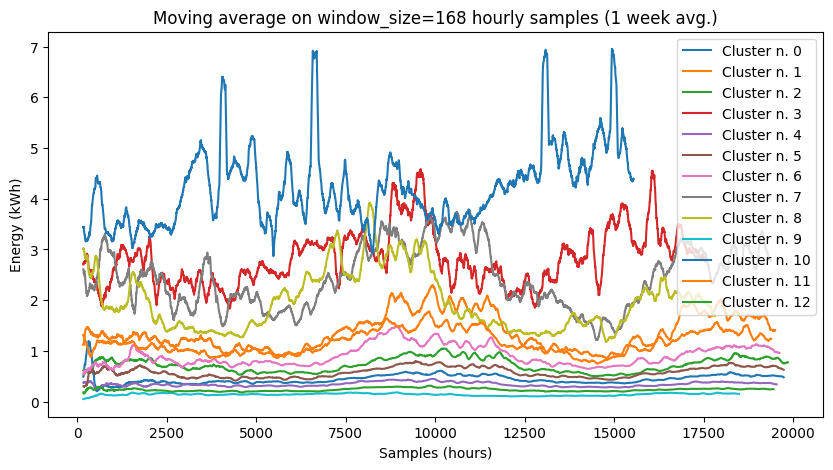

In [7]:
# PLOT THE MOVING AVERAGE FOR EACH CLUSTER TO SHOW THE NON-STATIONARITY

window_size = 24*7 # hrs in 1 week

plt.figure(figsize=(10,5))

for _cluster_id in range(max(df_time_mean_cluster['cluster']) + 1):
  # _cluster_id = 1
  __df = df_time_mean_cluster[df_time_mean_cluster['cluster'] == _cluster_id]

  # Rolling mean e rolling std
  rolling_mean = __df['energy(kWh)'].rolling(window=window_size).mean()
  plt.plot(range(0,len(__df)),rolling_mean, label=f'Cluster n. {_cluster_id}')

plt.title(f'Moving average on window_size={window_size} hourly samples (1 week avg.)')
plt.ylabel('Energy (kWh)')
plt.xlabel('Samples (hours)')
plt.legend()
plt.show()

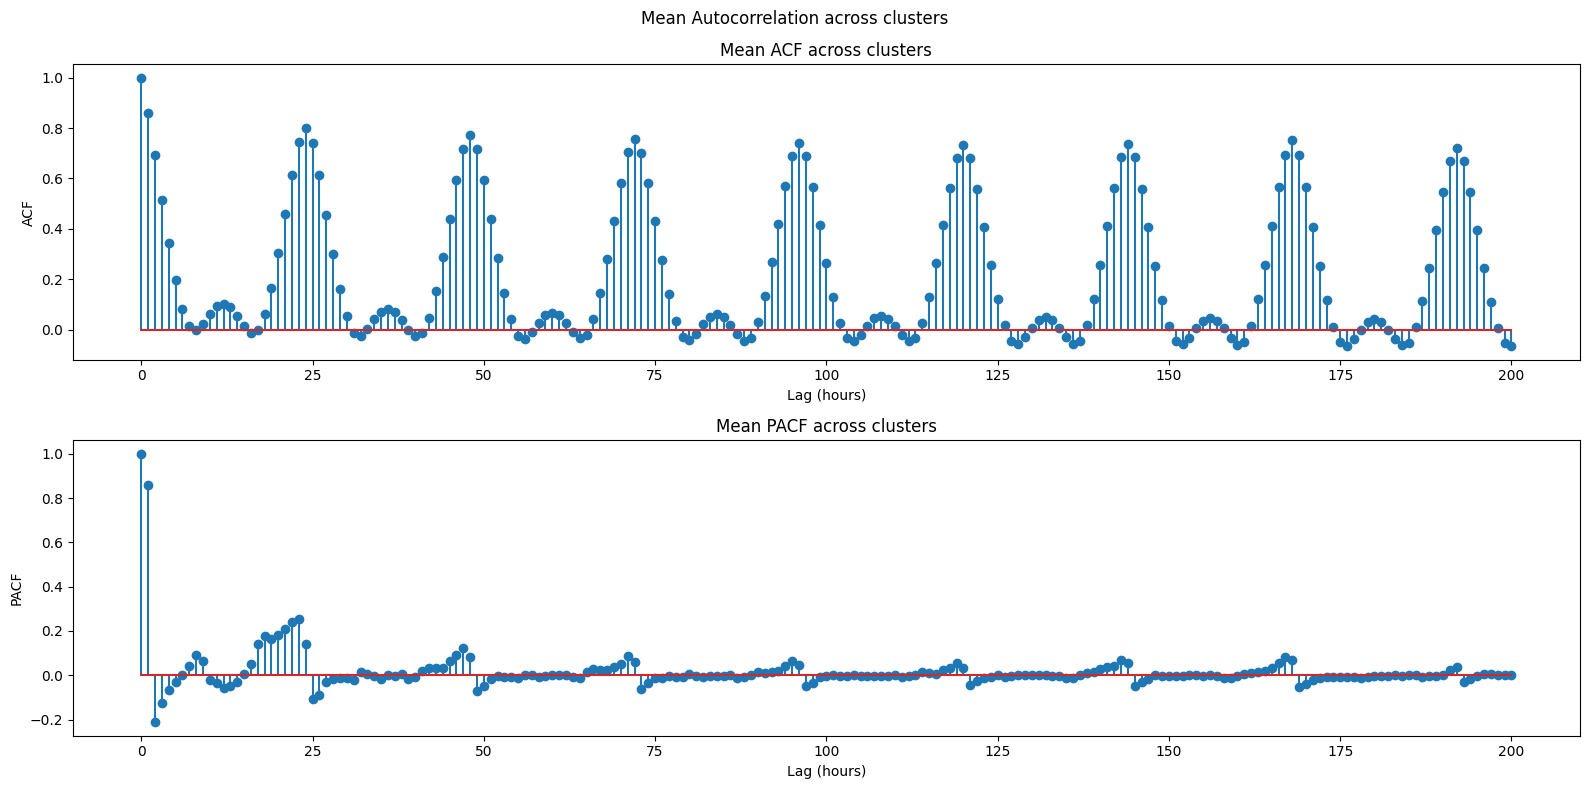

In [8]:
# ANALYSE THE AUTOCORRELATION TO IDENTIFY SEASONALITY

from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf

n_lags = 200

cluster_ids = sorted(df_time_mean_cluster['cluster'].unique())
n_clusters = len(cluster_ids)

acf_arr = np.zeros((n_clusters, n_lags + 1))
pacf_arr = np.zeros((n_clusters, n_lags + 1))

for idx, cluster_id in enumerate(cluster_ids):

    _df = df_time_mean_cluster[df_time_mean_cluster['cluster'] == cluster_id]

    acf_arr[idx, :] = acf(_df['energy(kWh)'], nlags=n_lags)
    pacf_arr[idx, :] = pacf(_df['energy(kWh)'], nlags=n_lags)

# Mean acf/pacf between clusters for each lag
acf_mean = np.mean(acf_arr, axis=0)
pacf_mean = np.mean(pacf_arr, axis=0)


# Plot the mean autocorrelation of the samples
_lags = np.arange(len(acf_mean))

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

# ACF mean
ax[0].stem(_lags, acf_mean,)
ax[0].set_title('Mean ACF across clusters')
ax[0].set_xlabel('Lag (hours)')
ax[0].set_ylabel('ACF')

# PACF mean
ax[1].stem(_lags, pacf_mean)
ax[1].set_title('Mean PACF across clusters')
ax[1].set_xlabel('Lag (hours)')
ax[1].set_ylabel('PACF')

plt.suptitle('Mean Autocorrelation across clusters')
plt.tight_layout()
plt.show()



In [9]:
# Analyse the daily max autocorrelation
__idx = range(0,n_lags+1,24)
acf_mean[__idx]

array([1.        , 0.8002248 , 0.77180184, 0.75664374, 0.74171203,
       0.73329319, 0.73833464, 0.75082425, 0.72250085])

### Feature engineering and LAGS + Train/Test split (function)

Create new features for hour, dayofweek, month. Then turn them into sin/cos values to express the seasonality over the day, the week and the month, so that samples near the same time have similar values.

Let's define the following time angles for the sin() functions:

$\theta_{hour}=2\pi\,\frac{hour\,of\,day}{24}$

$\theta_{day}=2\pi\,\frac{day\,of\,week}{7}$

$\theta_{month}=2\pi\,\frac{month\,of\,year}{12}$

In [10]:
def feature_eng(df: pd.DataFrame, lag_168=True):
  '''Create a new dataframe with time features'''

  X_tot = df.copy()
  # Create new features for hour, dayofweek, month
  X_tot['hour'] = X_tot['tstp'].dt.hour
  X_tot['dayofweek'] = X_tot['tstp'].dt.dayofweek
  X_tot['month'] = X_tot['tstp'].dt.month
  X_tot.drop(columns='tstp')

  # Turn the features into sin() values -> [also, in this way the values are normalized in (-1,+1)]
  X_tot['hour_sin'] = np.sin(2 * np.pi * X_tot['hour'] / 24)
  X_tot['day_sin'] = np.sin(2 * np.pi * X_tot['dayofweek'] / 7)
  X_tot['month_sin'] = np.sin(2 * np.pi * X_tot['month'] / 12)

  # Create lags to make methods like MLP have a memory and learn auto-correlation
  X_tot['lag_1'] = X_tot['energy(kWh)'].shift(1)
  X_tot['lag_24'] = X_tot['energy(kWh)'].shift(24)
  if lag_168:
    X_tot['lag_168'] = X_tot['energy(kWh)'].shift(168)

  # Remove unuseful/redundant features
  X_tot = X_tot.drop(columns=['hour', 'dayofweek', 'month'])

  # Convert 'tstp' to datetime
  X_tot['tstp'] = pd.to_datetime(X_tot['tstp'])

  # Set 'tstp' as index column
  X_tot = X_tot.set_index('tstp')

  # Remove NaN samples (first 168 rows), that have been created by the shifting
  return X_tot.dropna()



def train_test_split(X_tot: pd.DataFrame,
                     cluster_id, filter_cluster=True, train_ratio=0.7):
  '''Splits the time series into train and test sets'''

  if filter_cluster:
    # Filter the df taking only the samples with same cluster_id
    X_tot = X_tot[X_tot['cluster'] == cluster_id].copy()

  # Calc split indexes
  split_idx = int(len(X_tot) * train_ratio)

  # Train/Test dataset split
  X_tot_train = X_tot.iloc[:split_idx].astype(float)
  X_tot_test  = X_tot.iloc[split_idx:].astype(float)


  # Energy load time series
  y_train = X_tot_train['energy(kWh)']
  y_test = X_tot_test['energy(kWh)']

  # Features time series
  X_train = X_tot_train.drop(columns='energy(kWh)')
  X_test = X_tot_test.drop(columns='energy(kWh)')

  return y_train, y_test, X_train, X_test


In [11]:
# Check the total dataset after feature engineering
feature_eng(df_time_mean_cluster, lag_168=True)

,cluster,energy(kWh),hour_sin,day_sin,month_sin,lag_1,lag_24,lag_168
tstp,,,,,,,,
2011-12-05 12:00:00,0,0.206000,1.224647e-16,0.000000,-2.449294e-16,0.605000,0.142000,0.214000
2011-12-05 13:00:00,0,0.157000,-2.588190e-01,0.000000,-2.449294e-16,0.206000,1.136000,0.183000
2011-12-05 14:00:00,0,0.226000,-5.000000e-01,0.000000,-2.449294e-16,0.157000,1.797000,0.295000
2011-12-05 15:00:00,0,0.182000,-7.071068e-01,0.000000,-2.449294e-16,0.226000,1.157000,0.194000
2011-12-05 16:00:00,0,0.282000,-8.660254e-01,0.000000,-2.449294e-16,0.182000,1.969000,0.326000
...,...,...,...,...,...,...,...,...
2014-02-27 20:00:00,12,0.425733,-8.660254e-01,0.433884,8.660254e-01,0.408376,0.399634,0.389510
2014-02-27 21:00:00,12,0.412010,-7.071068e-01,0.433884,8.660254e-01,0.425733,0.406604,0.346598
2014-02-27 22:00:00,12,0.365426,-5.000000e-01,0.433884,8.660254e-01,0.412010,0.376297,0.333196


In [12]:
# Def. a comprehensive function, in order to be able to rapidly change cluster_ID

# CALL THE JUST CREATED FUNCTIONS to split the dataset, extract features and choose 1 cluster_ID

def extract_and_split_data(df_time_mean_cluster,
                           cluster_id,
                           train_ratio=0.7,
                           verbose=True):

  K = max(df_time_mean_cluster['cluster'])

  if cluster_id > K:
    raise ValueError(f'Cluster ID must be between 0 and {K}')

  # Call the feature engineering
  X_tot = feature_eng(df_time_mean_cluster)

  # for cluster_id in range(K):
  y_train, y_test, X_train, X_test = train_test_split(X_tot, cluster_id, train_ratio=train_ratio)

  if verbose:
    # Check
    print(f"CLUSTER_ID CONSIDERED: {cluster_id}")
    print('-'*30)
    print(f"y_train length: {len(y_train)}")
    print(f"y_test length: {len(y_test)}")

  return y_train, y_test, X_train, X_test

### Scoring functions

In [13]:
# Define score functions
# msre, rmsre, mae, mape, rmspe
# -------------------------

def _to_numpy(y_forecast, y_test):
    """Convert inputs to numpy arrays."""
    return np.asarray(y_forecast, dtype=float), np.asarray(y_test, dtype=float)


# Relative Error Metrics

def msre(y_forecast, y_test):
    """
    Mean Squared Relative Error (MSRE)
    MSRE = mean(((y_pred - y_true) / y_true)^2)
    """
    y_pred, y_true = _to_numpy(y_forecast, y_test)
    return np.mean(((y_pred - y_true) / y_true) ** 2)


def rmsre(y_forecast, y_test):
    """
    Root Mean Squared Relative Error (RMSRE)
    RMSRE = sqrt(MSRE)
    """
    return np.sqrt(msre(y_forecast, y_test))


# Absolute Error Metrics

def mae(y_forecast, y_test):
    """
    Mean Absolute Error (MAE)
    MAE = mean(|y_pred - y_true|)
    """
    y_pred, y_true = _to_numpy(y_forecast, y_test)
    return np.mean(np.abs(y_pred - y_true))


def mare(y_forecast, y_test):
    """
    Mean Absolute Relative Error (MARE)
    MARE = mean(|y_pred - y_true| / |y_true|)
    """
    y_pred, y_true = _to_numpy(y_forecast, y_test)
    return np.mean(np.abs(y_pred - y_true) / np.abs(y_true))


def mape(y_forecast, y_test):
    """
    Mean Absolute Percentage Error (MAPE)
    MAPE = 100 * mean(|(y_pred - y_true) / y_true|)
    """
    return 100 * mare(y_forecast, y_test)


def rmspe(y_forecast, y_test):
    """
    Root Mean Squared Percentage Error (RMSPE)
    RMSPE = 100 * sqrt(mean(((y_pred - y_true) / y_true)^2))
    """
    return 100 * rmsre(y_forecast, y_test)


### Cluster-level forecasting algorithms (functions)

In [14]:
# Utility plotting func

def show_test_results_func(model_name, cluster_id, y_train, y_test, _train_forecasts, test_forecasts,
                      perc_window_start, perc_window_end,
                      color_y_train, color_y_test, color_y_test_forecasts):
  '''Plot the results of the forecasting '''

  # --------------------------------------------------------
  # SCORE ON TRAIN: msre, rmsre, mae, mape, rmspe
  scores_train = {
      'msre': msre(_train_forecasts, y_train),
      'rmsre': rmsre(_train_forecasts, y_train),
      'mae': mae(_train_forecasts, y_train),
      'mape': mape(_train_forecasts, y_train),
      'rmspe': rmspe(_train_forecasts, y_train)
  }

  # SCORE ON TEST: msre, rmsre, mae, mape, rmspe
  scores_test = {
      'msre': msre(test_forecasts, y_test),
      'rmsre': rmsre(test_forecasts, y_test),
      'mae': mae(test_forecasts, y_test),
      'mape': mape(test_forecasts, y_test),
      'rmspe': rmspe(test_forecasts, y_test)
  }

  # Print the results
  print(f"SCORES ON TRAIN:\n")
  for k, v in scores_train.items():
    print(f"{k}\t{round(v,3)}")
  print('-'*30)
  print(f"SCORES ON TEST:\n")
  for k, v in scores_test.items():
    print(f"{k}\t{round(v,3)}")


  # PLOT THE RESULTS
  plt.figure(figsize=(10,5))
  plt.subplot(3,1,1)
  plt.plot(y_train.index, y_train, label='Train data', color=color_y_train)
  plt.plot(y_test.index, y_test, label='Test data', color=color_y_test)
  plt.plot(y_test.index, test_forecasts, label='Forecast on test', color=color_y_test_forecasts)
  plt.ylabel('Energy (kWh)')
  plt.legend()

  plt.subplot(3,1,2)
  plt.plot(y_test.index, y_test, label='Test data', color=color_y_test)
  plt.plot(y_test.index, test_forecasts, label='Forecast on test', color=color_y_test_forecasts)
  plt.ylabel('Energy (kWh)')
  plt.legend()
  # Analyse a shorter window of time
  plt.subplot(3,1,3)
  _idx_start = int(len(y_test)*perc_window_start)
  _idx_end = int(len(y_test)*perc_window_end)
  plt.plot(y_test.index[_idx_start:_idx_end], y_test[_idx_start:_idx_end], label='Test data', color=color_y_test)
  plt.plot(y_test.index[_idx_start:_idx_end], test_forecasts[_idx_start:_idx_end], label='Forecast on test', color=color_y_test_forecasts)
  plt.ylabel('Energy (kWh)')
  plt.legend()

  plt.xlabel('Time')
  # title subplot
  plt.suptitle(f'{model_name} - Cluster ID: {cluster_id}')
  plt.show()

In [15]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

# ARIMA ---------------------------------------------------

def ARIMA_func(y_train, y_test, cluster_id, order=(2,1,2),
               show_test_results=True,
               perc_window_start=0.4, perc_window_end=0.6):
  '''Train and test the ARIMA model (AutoRegressive Integrated Moving Average)'''

  # ARIMA model
  model_arima = ARIMA(y_train, order=order)
  # model_arima = SARIMAX(y_train,order=(1,1,1),seasonal_order=(1,1,1,24)) # <- TODO: try to use SARIMA (?)

  # fit the model
  model_arima_fit = model_arima.fit()

  # forecast on train (to assess bias and overfitting)
  _train_forecasts_arima = model_arima_fit.forecast(steps=len(y_train))
  _train_forecasts_arima = np.array(_train_forecasts_arima)

  # forecast on test
  test_forecasts_arima = model_arima_fit.forecast(steps=len(y_test))
  test_forecasts_arima = np.array(test_forecasts_arima)

  # Show the results
  if show_test_results:
    show_test_results_func(model_name=f'ARIMA - order: {order}', cluster_id=cluster_id,
                           y_train=y_train, y_test=y_test, _train_forecasts=_train_forecasts_arima,
                           test_forecasts=test_forecasts_arima,
                           perc_window_start=perc_window_start, perc_window_end=perc_window_end,
                           color_y_train='blue',
                           color_y_test='black',
                           color_y_test_forecasts='red')

  return test_forecasts_arima



# Decision Tree ---------------------------------------------------

def DT_func(y_train, y_test, X_train, X_test, cluster_id,
            show_test_results=True,
            perc_window_start=0.4, perc_window_end=0.6):
  '''Train and test the Decision Tree regressor model'''

  _max_depth = 5
  tree = DecisionTreeRegressor(max_depth=_max_depth, random_state=42)
  tree.fit(X_train, y_train)

  # Predict train data
  _train_forecasts = tree.predict(X_train)

  # Predict test data
  test_forecasts = tree.predict(X_test)

  # Training
  tree.fit(X_train, y_train)

  # Predictions on the train set
  _train_forecasts = tree.predict(X_train)
  # Predictions on the test set
  test_forecasts = tree.predict(X_test)

  # Show the results
  if show_test_results:
    show_test_results_func(model_name=f'Decistion Tree - max_depth: {_max_depth}', cluster_id=cluster_id,
                           y_train=y_train, y_test=y_test,
                           _train_forecasts=_train_forecasts, test_forecasts=test_forecasts,
                           perc_window_start=perc_window_start, perc_window_end=perc_window_end,
                           color_y_train='blue',
                           color_y_test='black',
                           color_y_test_forecasts='red')

  return test_forecasts



# MLP ---------------------------------------------------

def MLP_func(y_train, y_test, X_train, X_test, cluster_id,
             show_test_results=True, _hidden_layer_sizes=(32,16),
             _activation='relu', _solver='adam', _max_iter=500,
             perc_window_start=0.4, perc_window_end=0.6):
  '''Train and test the MLP NN Regressor model (Multi-Layer Perceptron)'''

  _hidden_layer_sizes = _hidden_layer_sizes
  _activation = _activation

  mlp = MLPRegressor(
      hidden_layer_sizes=_hidden_layer_sizes,
      activation=_activation,
      solver=_solver,
      max_iter=_max_iter,
      random_state=42)

  # Training
  mlp.fit(X_train, y_train)

  # Predictions on the train set
  _train_forecasts = mlp.predict(X_train)
  # Predictions on the test set
  test_forecasts = mlp.predict(X_test)

  # Show the results
  if show_test_results:
    show_test_results_func(model_name=f'MLP\nn. hidden layers: {_hidden_layer_sizes} - activation: {_activation}', cluster_id=cluster_id,
                           y_train=y_train, y_test=y_test,
                           _train_forecasts=_train_forecasts, test_forecasts=test_forecasts,
                           perc_window_start=perc_window_start, perc_window_end=perc_window_end,
                           color_y_train='blue',
                           color_y_test='black',
                           color_y_test_forecasts='red')

  return test_forecasts


In [16]:
# CHOOSE THE CLUSTER_ID
cluster_id = 0

# CALL THE FUNCTION TO PREPARE THE DATASET, SELECT THE CLUSTER_ID AND SPLIT THE DATA
y_train, y_test, X_train, X_test = extract_and_split_data(df_time_mean_cluster,
                                                          cluster_id=cluster_id,
                                                          train_ratio=0.7,
                                                          verbose=True)

CLUSTER_ID CONSIDERED: 0
------------------------------
y_train length: 13701
y_test length: 5872


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


SCORES ON TRAIN:

msre	0.544
rmsre	0.738
mae	0.169
mape	49.807
rmspe	73.786
------------------------------
SCORES ON TEST:

msre	0.27
rmsre	0.52
mae	0.156
mape	39.565
rmspe	51.958


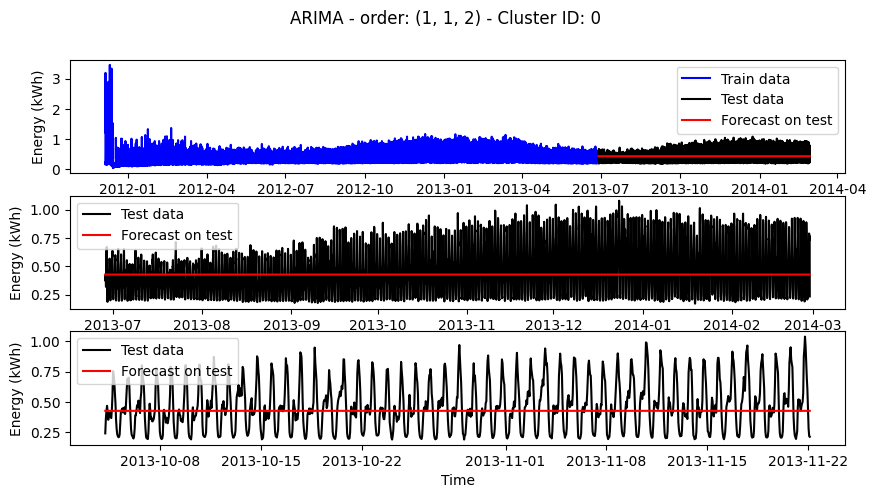

In [17]:
# ARIMA METHOD
order = (1,1,2)
test_forecasts_arima_cluster = ARIMA_func(y_train, y_test,
                                  cluster_id,
                                  order=order,
                                  show_test_results=True,
                                  perc_window_start=0.4,
                                  perc_window_end=0.6) # EXPERIMETS: order (2,1,2) - (1,1,1)


SCORES ON TRAIN:

msre	0.074
rmsre	0.273
mae	0.053
mape	13.314
rmspe	27.267
------------------------------
SCORES ON TEST:

msre	0.013
rmsre	0.113
mae	0.039
mape	8.61
rmspe	11.32


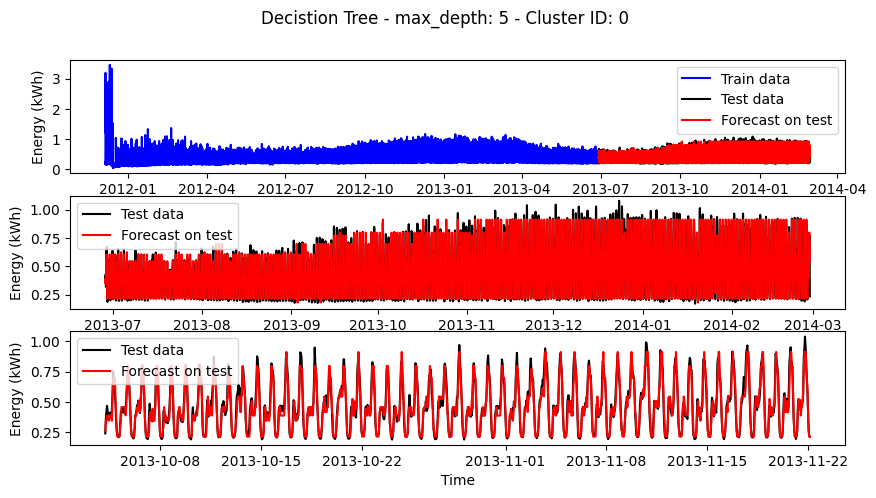

In [18]:
# DECISION TREE METHOD
test_forecasts_DT_cluster = DT_func(y_train, y_test, X_train, X_test, cluster_id,
                            show_test_results=True,
                            perc_window_start=0.4, perc_window_end=0.6)

SCORES ON TRAIN:

msre	0.068
rmsre	0.262
mae	0.052
mape	13.626
rmspe	26.152
------------------------------
SCORES ON TEST:

msre	0.013
rmsre	0.113
mae	0.038
mape	8.989
rmspe	11.341


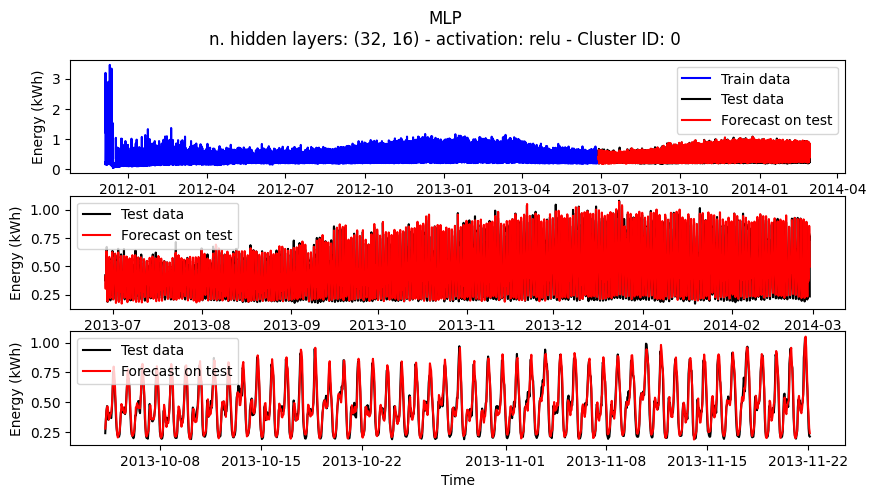

In [19]:
# MLP METHOD
test_forecasts_mlp_cluster = MLP_func(y_train, y_test, X_train, X_test, cluster_id,
                              show_test_results=True,
                              perc_window_start=0.4, perc_window_end=0.6)


# ILF: Individual Load Forecasting (with NN)

We previously forecasted the hourly electric load in a cluster level, representing on average all the households beloging in that cluster.

GOAL: now we want to split the hoourly load forecasts among each household (LCLid) in a specific cluster.

In [20]:
#def _(X_raw):
  #'''This function has not been utilized anymore.
  #(put data in columns for each timestamp -> problem: too many rows
  #have at least one NaN value)'''

  #X_ilf = X_raw.pivot(index='tstp', columns='LCLid', values='energy(kWh)')

In [52]:
from sklearn.preprocessing import StandardScaler

def prepare_df_ilf(df_time_clusterID:pd.DataFrame, df_time_mean_cluster, cluster_id):
  '''Take raw dataset, filter by cluster, add cluster hourly mean load,
  add LAGS features (1, 24) and sinusoidal values for timestamps '''

  X_raw = df_time_clusterID.copy()
  _dfc = df_time_mean_cluster.copy()
  _dfc = _dfc.rename(columns={'energy(kWh)': 'energy_mean_cluster'})

  X_raw = X_raw[X_raw['cluster'] == cluster_id].drop(columns=['cluster'])
  _dfc = _dfc[(_dfc['cluster'] == cluster_id)].drop(columns=['cluster'])

  X_ilf = X_raw.merge(_dfc, on='tstp', how='left')

  X_ilf_ready = feature_eng(X_ilf, lag_168=False)

  X_ilf_ready = X_ilf_ready.reset_index()

  # FACTORIZE the LCLid (smart meter ID) str values to assign a INT to each one
  int_IDs, LCLids = pd.factorize(X_train['LCLid'])
  print(int_IDs)
  print(LCLids)

  # Substitute the LCLids with the int_IDs
  X_ilf = X_ilf.drop(columns=['LCLid'])
  tot_ilf_test['int_IDs'] = int_IDs

  # Scale energy values for NN (since it uses a Gradient Descent, sensible to different scales)
  scaler = StandardScaler()
  _cols = ['energy(kWh)','energy_mean_cluster','lag_1','lag_24']
  X_ilf_ready[_cols] = scaler.fit_transform(X_ilf_ready[_cols])

  return X_ilf_ready, int_IDs, LCLids


In [53]:
# Use the function to prepare the dataset for the Individual Load Forecasting (ILF)
X_ilf_ready = prepare_df_ilf(df_time_clusterID, df_time_mean_cluster, cluster_id)

# Check NaN values
print(f"Check NaN values (must be 0):\n{X_ilf_ready.isna().sum()}")

X_ilf_ready

Check NaN values (must be 0):
tstp                   0
LCLid                  0
energy(kWh)            0
energy_mean_cluster    0
hour_sin               0
day_sin                0
month_sin              0
lag_1                  0
lag_24                 0
dtype: int64


,tstp,LCLid,energy(kWh),energy_mean_cluster,hour_sin,day_sin,month_sin,lag_1,lag_24
0,2012-10-13 00:00:00,MAC000002,0.171371,-0.809423,0.000000,-0.974928,-0.866025,0.231913,-1.021541
1,2012-10-13 01:00:00,MAC000002,0.169129,-1.091394,0.258819,-0.974928,-0.866025,0.171371,-1.021541
2,2012-10-13 02:00:00,MAC000002,-0.243456,-1.229869,0.500000,-0.974928,-0.866025,0.169128,-1.021541
3,2012-10-13 03:00:00,MAC000002,-0.393690,-1.232779,0.707107,-0.974928,-0.866025,-0.243456,-1.021541
4,2012-10-13 04:00:00,MAC000002,-0.402659,-1.250804,0.866025,-0.974928,-0.866025,-0.393691,-1.021541
...,...,...,...,...,...,...,...,...,...
1702971,2014-02-27 20:00:00,MAC005523,-0.685190,1.603877,-0.866025,0.433884,0.866025,-0.564106,-0.662772
1702972,2014-02-27 21:00:00,MAC005523,-0.712097,1.378597,-0.707107,0.433884,0.866025,-0.685191,-0.561868
1702973,2014-02-27 22:00:00,MAC005523,-0.756944,1.545353,-0.500000,0.433884,0.866025,-0.712098,-0.734526
1702974,2014-02-27 23:00:00,MAC005523,-0.671736,0.750191,-0.258819,0.433884,0.866025,-0.756944,-0.866822


In [54]:

_dfc_test = pd.DataFrame(columns=['tstp'])

_dfc_test['tstp'] = X_test.reset_index()['tstp']
_dfc_test['forecast(kWh)'] = test_forecasts_mlp_cluster

scaler = StandardScaler()
_cols = ['forecast(kWh)']
_dfc_test[_cols] = scaler.fit_transform(_dfc_test[_cols])

_dfc_test

,tstp,forecast(kWh)
0,2013-06-28 09:00:00,-0.272662
1,2013-06-28 10:00:00,-0.448439
2,2013-06-28 11:00:00,-0.676672
3,2013-06-28 12:00:00,-0.831463
4,2013-06-28 13:00:00,-0.786473
...,...,...
5867,2014-02-27 20:00:00,1.830656
5868,2014-02-27 21:00:00,1.489608
5869,2014-02-27 22:00:00,0.977313
5870,2014-02-27 23:00:00,0.702565


In [55]:
# Create a mask to select the test timestamps for each meter
mask = X_ilf_ready['tstp'].isin(_dfc_test['tstp'])

# Apply the mask and create the dataframe for the test and the training
tot_ilf_test  = X_ilf_ready[mask]
tot_ilf_train = X_ilf_ready[~mask]

# Set 'tstp' col as index
tot_ilf_test = tot_ilf_test.set_index('tstp')
tot_ilf_train = tot_ilf_train.set_index('tstp')

# Train/test split
y_ilf_train = tot_ilf_train['energy(kWh)']
X_ilf_train = tot_ilf_train.drop(columns='energy(kWh)')

y_ilf_test = tot_ilf_test['energy(kWh)']
X_ilf_test = tot_ilf_test.drop(columns='energy(kWh)')


In [68]:
tot_ilf_test

,LCLid,energy(kWh),energy_mean_cluster,hour_sin,day_sin,month_sin,lag_1,lag_24
tstp,,,,,,,,
2013-06-28 09:00:00,MAC000002,-0.034921,-0.174528,7.071068e-01,-0.433884,1.224647e-16,0.299182,0.895629
2013-06-28 10:00:00,MAC000002,-0.564105,-0.359729,5.000000e-01,-0.433884,1.224647e-16,-0.034922,0.911325
2013-06-28 11:00:00,MAC000002,-0.564105,-0.420494,2.588190e-01,-0.433884,1.224647e-16,-0.564106,0.173607
2013-06-28 12:00:00,MAC000002,-0.546167,-0.399227,1.224647e-16,-0.433884,1.224647e-16,-0.564106,-0.568595
2013-06-28 13:00:00,MAC000002,0.962905,-0.241722,-2.588190e-01,-0.433884,1.224647e-16,-0.546168,-0.568595
...,...,...,...,...,...,...,...,...
2014-02-27 20:00:00,MAC005523,-0.685190,1.603877,-8.660254e-01,0.433884,8.660254e-01,-0.564106,-0.662772
2014-02-27 21:00:00,MAC005523,-0.712097,1.378597,-7.071068e-01,0.433884,8.660254e-01,-0.685191,-0.561868
2014-02-27 22:00:00,MAC005523,-0.756944,1.545353,-5.000000e-01,0.433884,8.660254e-01,-0.712098,-0.734526


In [67]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten

def build_model_keras(num_ids, n_input_features, id_embedding_dim=8, h1=5, n_output_features=1):

    # Input ID
    id_input = Input(shape=(1,), name="id_input")  # ID smart meter
    id_emb = Embedding(input_dim=num_ids, output_dim=id_embedding_dim, name="id_embedding")(id_input)
    id_emb = Flatten()(id_emb)

    # Temporal input
    temp_input = Input(shape=(n_input_features,), name="temp_features")

    # Concatena embedding + feature temporali
    x = Concatenate()([temp_input, id_emb])

    # Hidden layer
    x = Dense(h1, activation='sigmoid')(x)

    # Output
    output = Dense(n_output_features, activation='linear')(x)

    model = Model(inputs=[temp_input, id_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model


# TRAINING
# ----------
# Dimensione input features temporali


model = build_model_keras(
    num_ids = len(X_ilf_ready['LCLid'].unique()),
    n_input_features = X_ilf_train.shape[1],
    id_embedding_dim = 8,
    h1 = 5,
    n_output_features = 1
    )

# Fit del modello
history = model.fit(
    x=X_ilf_train,
    y=y_train,
    validation_split=0.25,
    epochs=500,
    batch_size=64,
    verbose=1
)



# Plot the mse loss during the iterations in the training
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()



# Predictions
test_predictions = model.predict(X_ilf_test)




ValueError: Invalid dtype: object

In [48]:
tot_ilf_test

,energy(kWh),energy_mean_cluster,hour_sin,day_sin,month_sin,lag_1,lag_24
tstp,,,,,,,
2013-06-28 09:00:00,-0.034921,-0.174528,7.071068e-01,-0.433884,1.224647e-16,0.299182,0.895629
2013-06-28 10:00:00,-0.564105,-0.359729,5.000000e-01,-0.433884,1.224647e-16,-0.034922,0.911325
2013-06-28 11:00:00,-0.564105,-0.420494,2.588190e-01,-0.433884,1.224647e-16,-0.564106,0.173607
2013-06-28 12:00:00,-0.546167,-0.399227,1.224647e-16,-0.433884,1.224647e-16,-0.564106,-0.568595
2013-06-28 13:00:00,0.962905,-0.241722,-2.588190e-01,-0.433884,1.224647e-16,-0.546168,-0.568595
...,...,...,...,...,...,...,...
2014-02-27 20:00:00,-0.685190,1.603877,-8.660254e-01,0.433884,8.660254e-01,-0.564106,-0.662772
2014-02-27 21:00:00,-0.712097,1.378597,-7.071068e-01,0.433884,8.660254e-01,-0.685191,-0.561868
2014-02-27 22:00:00,-0.756944,1.545353,-5.000000e-01,0.433884,8.660254e-01,-0.712098,-0.734526


In [31]:
def _():
  '''Non used anymore, due to computation inefficencies that cause the Gcolab RAM to crash.
  I used a mask insted (see above)'''

  # Filter X_ilf to get the test set
  tot_ilf_test = X_ilf_ready[X_ilf_ready['tstp'].isin(_dfc_test['tstp'])]

  # Drop the filtered test rows from the total dataset, to get the training dataset
  tot_ilf_train = X_ilf_ready.drop(tot_ilf_test.index)

  # Split the training features from target
  y_ilf_train = tot_ilf_train['energy(kWh)']
  X_ilf_train = tot_ilf_train.drop(columns='energy(kWh)')

  # Split test features from target
  y_ilf_test = tot_ilf_test['energy(kWh)']
  X_ilf_test = tot_ilf_test.drop(columns='energy(kWh)')

  # Check test features
  X_ilf_test

/tmp/ipython-input-2523902488.py:18: RuntimeWarning: divide by zero encountered in divide
  return np.mean(((y_pred - y_true) / y_true) ** 2)
/tmp/ipython-input-2523902488.py:46: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(y_pred - y_true) / np.abs(y_true))


SCORES ON TRAIN:

msre	inf
rmsre	inf
mae	0.186
mape	inf
rmspe	inf
------------------------------
SCORES ON TEST:

msre	inf
rmsre	inf
mae	0.179
mape	inf
rmspe	inf


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


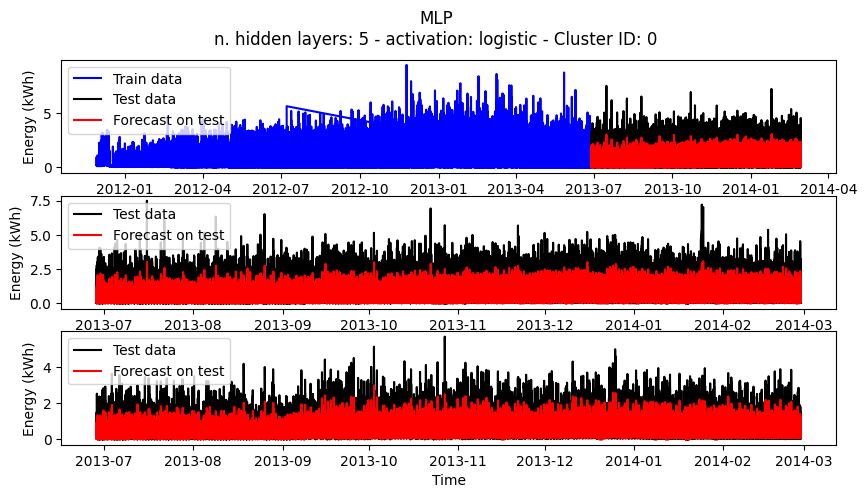

In [43]:
# Train and test the NN MLP, with logistic 1 hidden layer of 5 Sigmoid activation functions
forecasts = MLP_func(y_ilf_train, y_ilf_test, X_ilf_train, X_ilf_test, cluster_id,
                     show_test_results=False, _hidden_layer_sizes=(5),
                     _activation='logistic', _solver='adam', _max_iter=500,
                     perc_window_start=0.4, perc_window_end=0.6)



In [38]:
forecasts

array([ 0.3648392 ,  0.08604967, -0.41691382, ..., -0.47602205,
       -0.63072537, -0.72325872])